In [1]:
from time import process_time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def tinferior(A, b):
    n = A.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(A[i,:i], x[:i])) / A[i,i]
    return x

def tsuperior(A, b):
    n = A.shape[0]
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (b[i] - np.dot(A[i,i+1:], x[i+1:])) / A[i,i]
    return x

def DLU(A):
    D = np.diag(np.diag(A))
    L = (np.tril(A) - D)*(-1)
    U = (np.triu(A) - D)*(-1)
    return D,L,U



def LU(A, b):
    n = A.shape[0]
    L = np.identity(n)
    U = np.array(A, dtype=np.float64)

    for k in range(n):
        for j in range(k+1, n):
            L[j,k] = U[j,k] / U[k,k]
            U[j,k:] -= L[j,k] * U[k,k:]

    z = tinferior(L, b)
    x = tsuperior(U, z)

    return x



def Jacobi(A,b):
    n=A.shape[0]
    D,L,U=DLU(A)
    M = D
    Mi=np.linalg.inv(M)
    N=L+U

    J=np.dot(Mi,N)

    x=np.zeros(n)
    d=True

    while d is True:
      xk=np.dot(J,x)+np.dot(Mi,b)
      if np.linalg.norm(x-xk)<10**(-6):
        d=False
      x=xk

    return x



def GS(A,b):
    
    n=A.shape[0]
    D,L,U=DLU(A)
    M=D-L
    Mi=np.linalg.inv(M)
    N=U
    
    J=np.dot(Mi,N)
    
    x=np.zeros(n)
    d=True
  
    while d is True:
      xk=np.dot(J,x)+np.dot(Mi,b)
      if np.linalg.norm(x-xk)<10**(-6):
        d=False
      x=xk
  
    return x



def SOR(A,b):
  n=A.shape[0]
  D,L,U=DLU(A)
  eigenvalues = np.linalg.eigvals(np.linalg.inv(D)@(L+U))
  spectral_radius = max(eigenvalues)
  w = 2 / (1+(1-spectral_radius**2)**(1/2))

  M=(1/w)*(D-w*L)
  Mi=np.linalg.inv(M)
  N=(1/w)*((1-w)*D+w*U)

  J=np.dot(Mi,N)

  x=np.zeros(n)
  d=True

  while d is True:
    xk=np.dot(J,x)+np.dot(Mi,b)
    if np.linalg.norm(x-xk)<10**(-6):
      d=False
    x=xk

  return x

def inverse_tridiagonal(A,b):
    n = len(A)
    x = np.zeros(n)
    for i in range(1,n):
        A[i,i] = A[i,i] - (A[i,i-1]/A[i-1,i-1])*A[i-1,i]
        b[i] = b[i] - (A[i,i-1]/A[i-1,i-1])*b[i-1]
    
    x[n-1] = b[n-1]/A[n-1,n-1]

    for i in range(n-2,1,-1):
        x[i] = (b[i]-A[i,i+1])/A[i,i]

    return x

def tridiagonal_matrix(n, a, b, c):
    matrix = np.zeros((n, n))
    np.fill_diagonal(matrix[1:], a)  # Fill subdiagonal
    np.fill_diagonal(matrix, b)       # Fill diagonal
    np.fill_diagonal(matrix[:, 1:], c)  # Fill superdiagonal
    return matrix

def generate_b(n):
   b = np.zeros(n)
   for i in range(n):
      b[i] = (1/(n+1))**2 * ((i+1)/(n+1))**2
   return b

In [ ]:
sizes = [2**k for k in range(2,15)]
times_LU = []
times_Jacobi = []
times_GS = []
times_SOR = []



for n in sizes:
    A = tridiagonal_matrix(n, 1, -2, 1)
    b = generate_b(n)

    # Resolver usando el método LU
    t = process_time()
    x_LU = LU(A,b)
    times_LU.append(process_time() - t)

    # Resolver usando el método de Jacobi
    t = process_time()
    x_Jacobi = Jacobi(A,b)
    times_Jacobi.append(process_time() - t)

    # Resolver usando el método de Gauss-Seidel
    t = process_time()
    x_Gauss_Seidel = GS(A,b)
    times_GS.append(process_time() - t)

    # Resolver usando el método SOR
    t = process_time()
    x_SOR = SOR(A,b)
    times_SOR.append(process_time() - t)
    

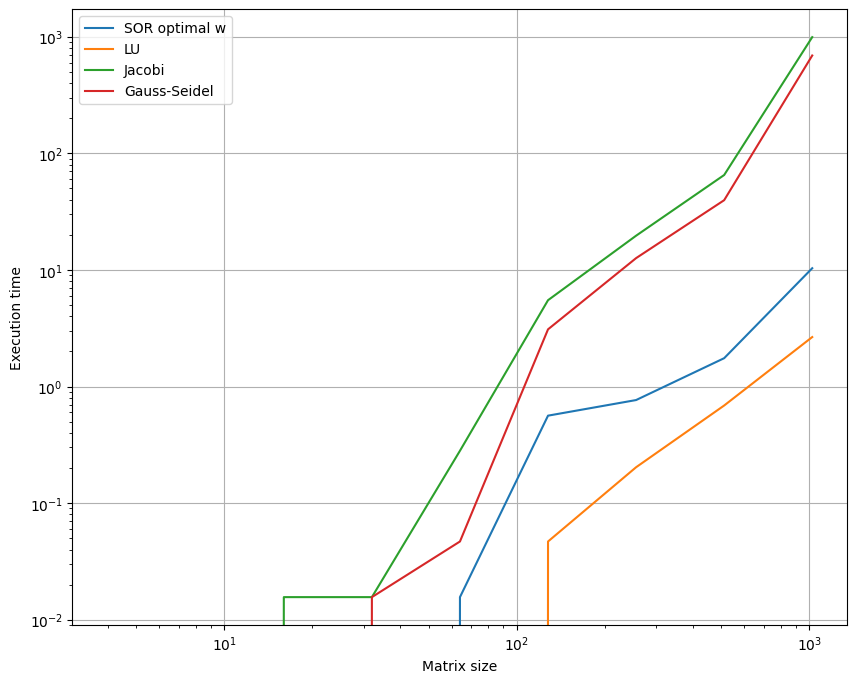

In [32]:
n = len(times_SOR)
plt.figure(figsize=(10, 8))
plt.loglog(sizes[:n], times_SOR[:n], label='SOR optimal w')
plt.loglog(sizes[:n], times_LU[:n], label='LU')
plt.loglog(sizes[:n], times_Jacobi[:n], label='Jacobi')
plt.loglog(sizes[:n], times_GS[:n], label='Gauss-Seidel')
plt.xlabel('Matrix size')
plt.ylabel('Execution time')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
def generate_b_perturbed(n):
   b = np.zeros(n)
   for i in range(n):
      b[i] = (1/(n+1))**2 * (((i+1)/(n+1))**2+0.05)
   return b

In [18]:
sizes = [2**k for k in range(2,15)]

errors = []
bounds = []
for n in sizes[:9]:
    ## Not perturbed
    A = tridiagonal_matrix(n, 1, -2, 1)
    b = generate_b(n)
    x_direct = inverse_tridiagonal(A,b)

    ## Perturbed
    b_perturbed = generate_b_perturbed(n)
    x_direct_perturbed = inverse_tridiagonal(A,b)

    errors.append(np.linalg.norm((b_perturbed-b), ord=2)/np.linalg.norm((b), ord=2))

    eigen = np.linalg.eigvals( A@A.T)
    bounds.append( np.sqrt(max(eigen)/min(eigen)))


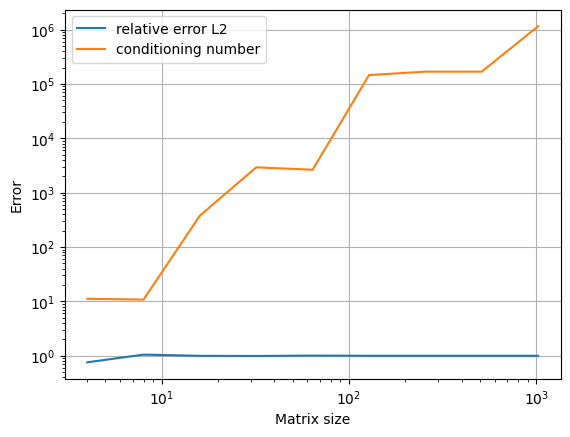

In [19]:
plt.loglog(sizes[:9], errors, label='relative error L2')
plt.loglog(sizes[:9], bounds, label='conditioning number')
plt.xlabel('Matrix size')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
bounds

[11.169510519161834,
 10.804596395434858,
 378.7631433225924,
 2922.0201497496737,
 2638.7771200358457,
 145229.2926442315,
 168171.5937653221,
 168171.59367553986,
 1145625.3435622326]

In [39]:
relative_error

0.8777796123122152

In [41]:
eigen = np.linalg.eigvals( A@A.T)
kappa = np.sqrt(max(eigen)/min(eigen))
kappa

11.916018689432386